In [26]:
# I played around with different numbers of estimators and different numbers of features, without ever boosting
# accuracy much over 84%

#From A. Muller https://github.com/amueller/mglearn/blob/master/mglearn/tools.py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, colorConverter, LinearSegmentedColormap
import pandas as pd
import os
%matplotlib inline

#set datadir based on cwd
cwd = os.getcwd()

#OSX
datadir = cwd + '/data/'
df = pd.read_csv(datadir+'data_clean.csv',index_col=0)

#Windows
#datadir = cwd + '\\data\\'
#df = pd.read_csv(datadir+'data_clean.csv')

In [27]:
# added a random_state so we will get the same results each time we run
train_df = df.sample(frac=0.7, replace=False, random_state = 42)
test_df = df[~df.index.isin(train_df.index)]

#check if train_df and test_df overlap
len(train_df) + len(test_df) == len(df)

True

In [28]:
#Declare target variable, training data and testing data
target = 'NewArrest36'
train = train_df
test = test_df

#Set up X Y
X_train = train.drop(target, 1)
Y_train = train[target]
X_test = test.drop(target, 1)
Y_test = test[target]

Feature Selection

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf_best = RandomForestClassifier(criterion='entropy')
rf_best = rf_best.fit(X_train, Y_train)

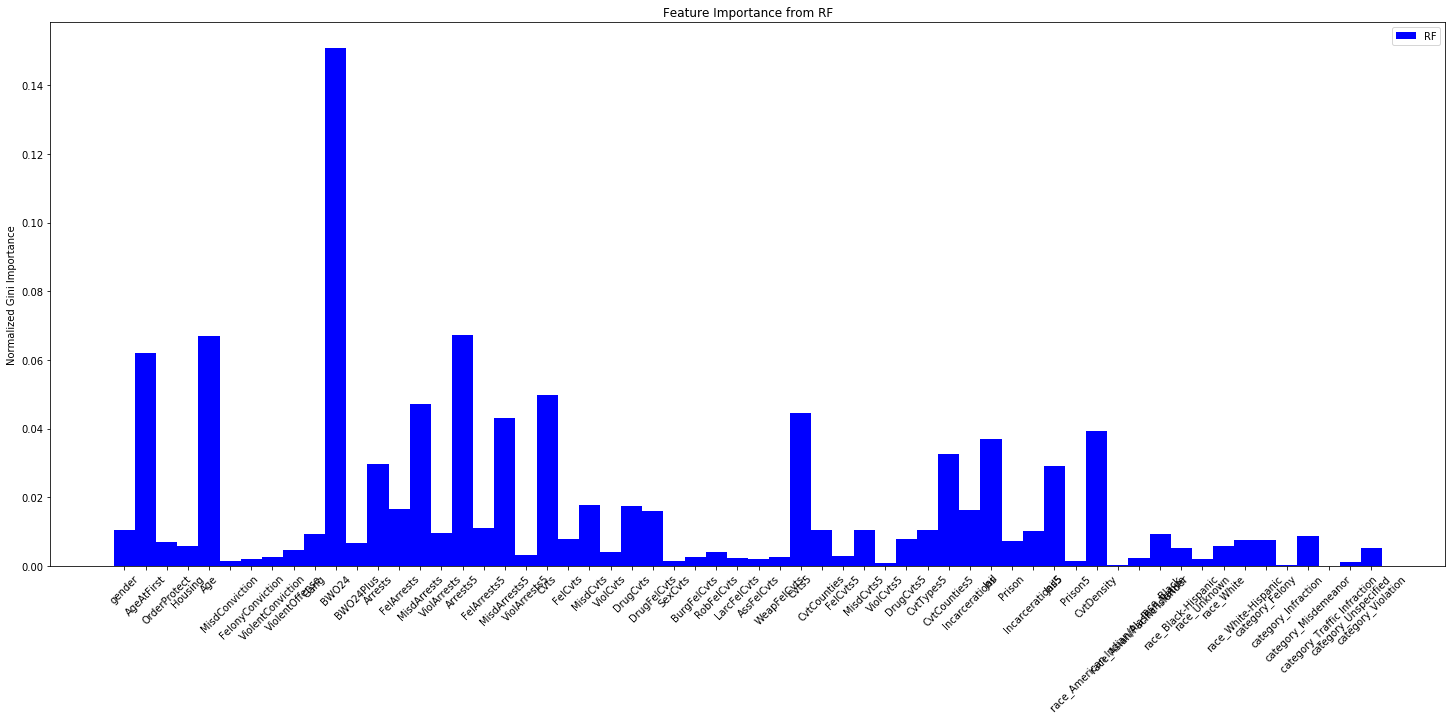

In [35]:
%matplotlib inline
cols = X_train.columns.values
rf_fi = rf_best.feature_importances_

fig, ax = plt.subplots(figsize=(25, 10))

ax.bar(np.arange(len(cols)), rf_fi, width, color='b', label='RF')


ax.set_xticks(np.arange(len(cols)))
ax.set_xticklabels(cols, rotation=45)
plt.title('Feature Importance from RF')
ax.set_ylabel('Normalized Gini Importance')
plt.legend(loc=1)

We see some feature_importance score are almost zero, so we get rid of them to build the baseline RF model(please include the above plot in the write-up)

In [41]:
feature_imp_dict = dict(zip(X_train.columns.values, pd.Series(rf_fi)))
feat_imp_df = pd.DataFrame(pd.Series(feature_imp_dict), columns = ['feat_imp'])
feat_imp_df['feat_imp'] = feat_imp_df['feat_imp'].apply(lambda x: '%.3f' % x)
feat_imp_df = feat_imp_df[feat_imp_df['feat_imp'] != 0]

With the remaining 60 features, we build the first baseline RF model with the default setting 

/Users/Stella/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:451: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/Stella/miniconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:456: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


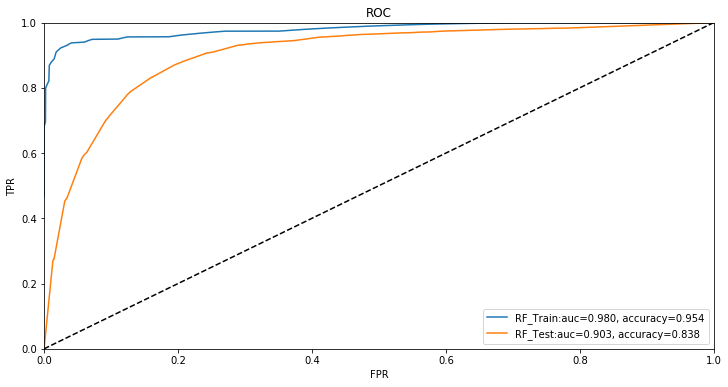

In [76]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score

# leave X_train just as it was
X_train = X_train[list(feat_imp_df.index.values)]
X_test = X_test[list(feat_imp_df.index.values)]

rf_def = RandomForestClassifier(criterion='entropy',oob_score=True)
rf_def = rf_def.fit(X_train, Y_train)

rf_pred_test = rf_def.predict_proba(X_test)[:,1]
rf_pred_train = rf_def.predict_proba(X_train)[:,1]
rd_pred_oob = rf_def.oob_decision_function_[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, rf_pred_test)
roc_auc = auc(fpr, tpr)
accuracy = rf_def.score(X_test, Y_test)

fpr1, tpr1, thresholds1 = roc_curve(Y_train, rf_pred_train)
roc_auc1 = auc(fpr1, tpr1)
accuracy1 = rf_def.score(X_train, Y_train)


#Plotting
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

plt.plot(fpr1,tpr1,label="RF_Train:auc=%.3f, accuracy=%.3f" % (roc_auc1,accuracy1))
plt.plot(fpr,tpr,label="RF_Test:auc=%.3f, accuracy=%.3f" % (roc_auc,accuracy))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend(loc="lower right")
plt.show()




Our baseline RF model has the auc = 0.903 and acuracy = 0.835, which is good, however, we will continue to tunning the hyper-parameters to improve the model. <br/>
There are two hyper-parameters that determines the complexity of the RF model: <br/>
n_estimators - the number of trees (and bootstrapped samples) to be used  <br/>
max_features - the number of features that will be randomly sampled for each tree.<br/>


Instead of using cross-validation to choose the hypter-parameter, in RF model, we calcualte the out-of-bag error, which would save much time

In [57]:
n_est = [200, 500, 1000, 1500]
m_feat = [10, 20, 30,40,50,60]

aucs_oob = {}
aucs_test = {}

for m in m_feat:
    aucs_oob[m] = []
    aucs_test[m] = []
    for n in n_est:
        rf_oob = RandomForestClassifier(criterion='entropy', n_estimators=n, max_features=m, oob_score=True)
        rf_oob = rf_oob.fit(X_train, Y_train)
        aucs_oob[m].append(roc_auc_score(Y_train, rf_oob.oob_decision_function_[:,1]))
        aucs_test[m].append(roc_auc_score(Y_test, rf_oob.predict_proba(X_test)[:,1]))

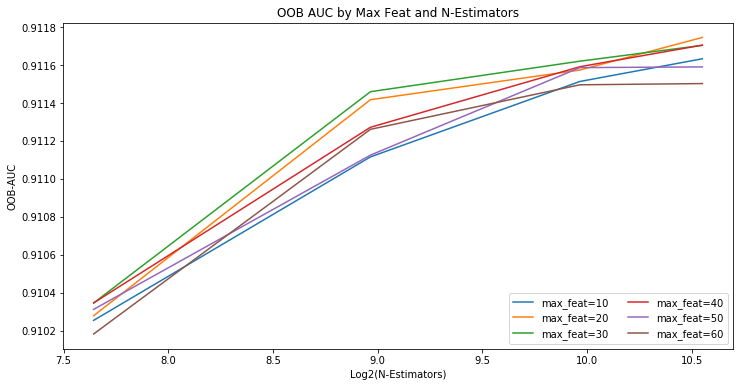

In [58]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

x = np.log2(np.array(n_est))
for m in m_feat:
    plt.plot(x, aucs_oob[m], label='max_feat={}'.format(m))
    
plt.title('OOB AUC by Max Feat and N-Estimators')
plt.xlabel('Log2(N-Estimators)')
plt.ylabel('OOB-AUC')
plt.legend(loc=4, ncol=2, prop={'size':10})
plt.show()

We could see that as the number of tree grows, it predicts better, however, with less features, the effect of growing trees seems to taper off. With less features(max_feat = 10), the bias goes up, while having too much features(max_feat = 60), it creats high variance as well. We saw the green line(max_feat = 30) and orange line(max_feat = 20) performs better than other lines, and the number of features were all optimal choices. We could take a look at the test_auc score and pick a better one. 

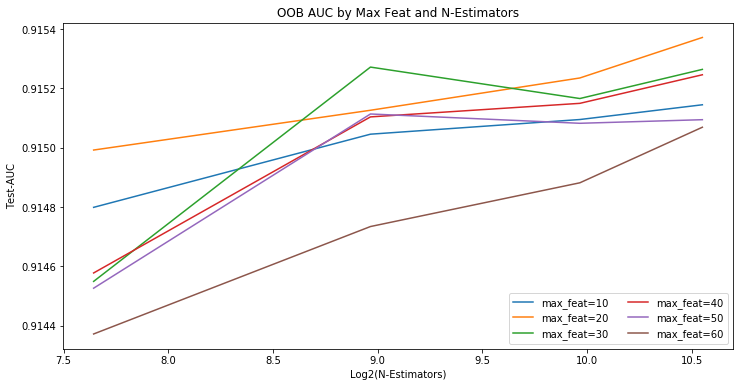

In [68]:
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

x = np.log2(np.array(n_est))
for m in m_feat:
    plt.plot(x, aucs_test[m], label='max_feat={}'.format(m))
    
plt.title('OOB AUC by Max Feat and N-Estimators')
plt.xlabel('Log2(N-Estimators)')
plt.ylabel('Test-AUC')
plt.legend(loc=4, ncol=2, prop={'size':10})
plt.show()

By looking at the test_auc score, our choice of max_feat = 30 was determined. We could see that, with the most feature, the max_feat = 60 doesn't perform well compared to all other max_feat; in addition, when looking at the green line and the orange line, with the max_feat = 30, and 20 respectively, we saw green line reached at test_auc = 0.9153 when n_estimator = 900, and the orange line seems to keep growing as n_estimator grows. In this case, we build two models with these two options of hyper-parameters and evaluate them. 

2nd RF Models

In [80]:
import timeit
start = timeit.default_timer()

rf_def1 = RandomForestClassifier(criterion='entropy',n_estimators = 900, max_features=30, oob_score=True)
rf_def1 = rf_def1.fit(X_train, Y_train)
rf_pred1 = rf_def1.predict_proba(X_test)[:,1]

fpr3, tpr3, thresholds3 = roc_curve(Y_test, rf_pred1)
roc_auc3 = roc_auc_score(Y_test, rf_pred1)
oob3 = roc_auc_score(Y_train, rf_def1.oob_decision_function_[:,1])


stop = timeit.default_timer()
print(stop - start)

278.70425696700113


In [81]:
start = timeit.default_timer()

rf_def2 = RandomForestClassifier(criterion='entropy',n_estimators = 1500, max_features=20, oob_score=True)
rf_def2 = rf_def2.fit(X_train, Y_train)
rf_pred2 = rf_def2.predict_proba(X_test)[:,1]

fpr1, tpr1, thresholds1 = roc_curve(Y_test, rf_pred2)
roc_auc1 = roc_auc_score(Y_test, rf_pred2)
oob1 = roc_auc_score(Y_train, rf_def2.oob_decision_function_[:,1])

stop = timeit.default_timer()
print(stop - start)

373.3618655469909


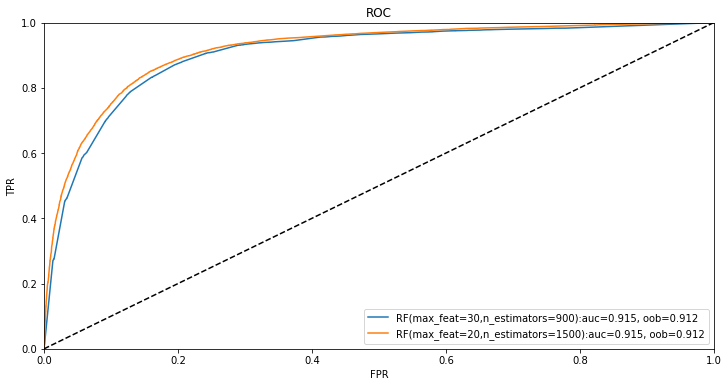

In [82]:
#Plotting
fig = plt.figure(figsize = (12, 6))
ax = plt.subplot(111)

plt.plot(fpr,tpr,label="RF(max_feat=30,n_estimators=900):auc=%.3f, oob=%.3f" % (roc_auc3,oob3))
plt.plot(fpr1,tpr1,label="RF(max_feat=20,n_estimators=1500):auc=%.3f, oob=%.3f" % (roc_auc1,oob1))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC")
plt.legend(loc="lower right")
plt.show()

The 2nd and 3rd RF models with hyper-parameters options (max_feat = 30, n_estimator = 900), (max_feat = 20, n_estimator = 1500) has the same auc score when we format the auc_score to 3 decimal digits. In this case, we calculate the time running for both models. 2nd model takes 270s, and the 3rd model takes around 370s. With the same auc_score, the 3rd model is more complex than the 2nd one, so we ended up using the RF model with the hyper-parameters as: max_feat = 30, n_estimators = 900.